Original notebook by [Patrick Gray](https://github.com/patrickcgray)


vector data in python using GeoPandas
==========================================

## Introduction

The *OGR* library is a companion library to *GDAL* that handles vector data capabilities, including information queryies, file conversions, rasterization of polygon features, polygonization of raster features, and much more. It handles popular formats including the *ESRI Shapefile*, *Keyhole Markup Language*, *PostGIS*, and *SpatiaLite*. For more information on how *OGR* came about and how it relates to *GDAL*, see here: http://trac.osgeo.org/gdal/wiki/FAQGeneral#WhatisthisOGRstuff.

In this tutorial we'll be working with: 
* [Shapely](https://shapely.readthedocs.io/en/stable/manual.html): `shapely` does things like buffers, unions, intersections, centroids, convex hulls, and lots more.
  * `shapely` is a BSD-licensed Python package for manipulation and analysis of planar geometric objects. It is based on the widely deployed GEOS (the engine of PostGIS) and JTS (from which GEOS is ported) libraries. Shapely is not concerned with data formats or coordinate systems, but can be readily integrated with packages that are.
* [Fiona](https://fiona.readthedocs.io/en/latest/): `fiona` does reading and writing data formats.
 * `fiona` is OGR's neat and nimble API for Python programmers. It focuses on reading and writing data in standard Python IO style and relies upon familiar Python types and protocols such as files, dictionaries, mappings, and iterators instead of classes specific to OGR. `fiona` can read and write real-world data using multi-layered GIS formats and zipped virtual file systems and integrates readily with other python GIS packages such as `pyproj`, `Rtree`, and `Shapely`.
* [Geopandas](http://geopandas.org/): GeoPandas is an open source project to make working with geospatial data in python easier. 
  * GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.
  * The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.
  
Let's explore shapely a bit by creating some shapes:

In [1]:
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon

import matplotlib.pyplot as plt
%matplotlib inline

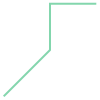

In [2]:
a = LineString([(0, 0), (1, 1), (1,2), (2,2)])
a

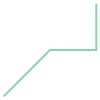

In [3]:
b = LineString([(0, 0), (1, 1), (2,1), (2,2)])
b

With these two lines created we can run some geospatial operations on them like an intersection:

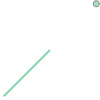

In [4]:
x = b.intersection(a)
x

We can buffer shapes too.

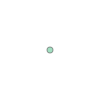

In [5]:
c = Point(1, 1)
c

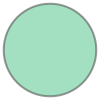

In [6]:
c = c.buffer(1.5)
c

We can do intersections:

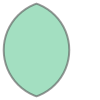

In [7]:
d = Point(2, 1).buffer(1.5)
c.intersection(d)

Or we can do a union instead of an intersection.

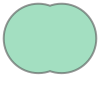

In [8]:
c.union(d)

So far we've just been using the default plotting in Jupyter notebooks. Let's shift now to plotting with matplotlib.

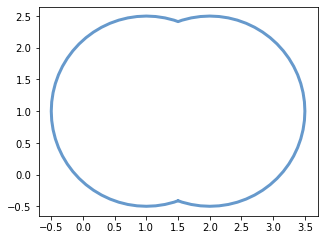

In [9]:
BLUE = '#6699cc'
GRAY = '#999999'

fig, ax = plt.subplots(figsize=(5, 5))
x, y = c.union(d).exterior.xy # find all the x and y points in the shape
ax.plot(x, y, color=BLUE, linewidth=3, solid_capstyle='round')
ax.set_aspect('equal') # make the axes equal so the shape isn't distorted
plt.show()

Now let's do something a little more complicated. We're going to plot a line and then buffer around that line in Subplot 1 and then in Subplot 2 we'll plot that buffer and then erode the buffer and plot it on top of the full buffer.

Here we'll use `descartes` to plot these polygon patches in `matplotlib`:

This is of course just a taste. You can do all sorts of cool geometric operations with shapely.

We'll now use an *ESRI Shapefile* that contains training data I collected for the example image we've been working on.

## Opening an *ESRI Shapefile*

Just like *GDAL* in `rasterio`, *OGR* in `fiona` abstracts the file formats so that we can use the same code for any format. It employs the same concept of a *dataset* object which we can gather information from:

### Using fiona to import shapefiles 

In [10]:
import fiona
# Open the dataset from the file
shapefile = fiona.open('./data/rcr/rcr_landcover.shp')
# Make sure the dataset exists -- it would be None if we couldn't open it
if not shapefile:
    print('Error: could not open shapefile')

With our Shapefile read in, we can look at some of its properties:

In [11]:
### Let's get the driver from this file
driver = shapefile.driver
print('Dataset driver is: {n}\n'.format(n=driver))

Dataset driver is: ESRI Shapefile



In [12]:
### How many features are contained in this Shapefile?
feature_count = len(shapefile)
print('The shapefile has {n} feature(s)\n'.format(n=feature_count))

The shapefile has 65 feature(s)



In [13]:
### What is the shapefiles's projection?
# Get the spatial reference
spatial_ref = shapefile.crs
print('The shapefiles spatial ref is:\n', spatial_ref, '\n')

The shapefiles spatial ref is:
 {'init': 'epsg:32618'} 



In [14]:
# Let's pull out a specific feature from the shapefile
feature = shapefile[0]

### What is the features's geometry? is it a point? a polyline? a polygon?
geometry = feature['geometry']['type']
print("The features's geometry is: {geom}".format(geom=geometry))

### How many properties are in the shapefile, and what are their names?
properties = feature["properties"].keys()

# How many fields
field_count = len(properties)
print('Layer has {n} fields'.format(n=field_count))

# What are their names?
print('Their names are: ')
for prop in properties:
    print('\t{name}'.format(name=prop))

The features's geometry is: Polygon
Layer has 2 fields
Their names are: 
	Classname
	Classvalue


In [15]:
# you can get a quick view of all of this
shapefile.meta

{'driver': 'ESRI Shapefile',
 'schema': {'properties': OrderedDict([('Classname', 'str:80'),
               ('Classvalue', 'int:18')]),
  'geometry': 'Polygon'},
 'crs': {'init': 'epsg:32618'},
 'crs_wkt': 'PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]'}

The shapefile is a list of features, which can be accessed like any python list

In [16]:
feature = shapefile[0]
feature # The result is a Python dictionary

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('Classname', 'Sand'), ('Classvalue', 2253)]),
 'geometry': {'type': 'Polygon',
  'coordinates': [[(348481.6873325305, 3841625.9444273096),
    (348470.87445113715, 3841610.6314272936),
    (348423.6331232535, 3841637.184122987),
    (348445.40837316494, 3841652.3160573784),
    (348481.6873325305, 3841625.9444273096)]]}}

As all dictionaries in Python, there are keys and values.

In [17]:
feature.keys()

dict_keys(['type', 'id', 'properties', 'geometry'])

In [18]:
print('id: ', feature['id']) #gives the id
print('Classname: ', feature['properties']['Classname']) # gives the value of the classname attribute

print('\ngeometry: ', feature['geometry']) # gives the geometry, GeoJSON format

id:  0
Classname:  Sand

geometry:  {'type': 'Polygon', 'coordinates': [[(348481.6873325305, 3841625.9444273096), (348470.87445113715, 3841610.6314272936), (348423.6331232535, 3841637.184122987), (348445.40837316494, 3841652.3160573784), (348481.6873325305, 3841625.9444273096)]]}


If you want to transform this geometry into a shapely geometry use the shape function that we imported earlier

<class 'shapely.geometry.polygon.Polygon'>


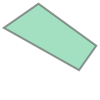

In [19]:
shapely_shape = shape(feature['geometry'])
print(type(shapely_shape))

shapely_shape

We'll come back to this set of training features later!

## Bringing in the real power tools: `geopandas`

Geopandas takes the tools we have seen so far to the next level.

The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

From the docs:

    GeoPandas implements two main data structures, a GeoSeries and a GeoDataFrame. These are subclasses of pandas Series and DataFrame, respectively.

    A GeoSeries is essentially a vector where each entry in the vector is a set of shapes corresponding to one observation.

    A GeoDataFrame is a tabular data structure that contains a GeoSeries.

    The most important property of a GeoDataFrame is that it always has one GeoSeries column that holds a special status. This GeoSeries is referred to as the GeoDataFrame‘s “geometry”. When a spatial method is applied to a GeoDataFrame (or a spatial attribute like area is called), this commands will always act on the “geometry” column

Let's show a simple example.

In [20]:
import geopandas as gpd

p1 = Polygon([(0, 0), (1, 0), (1, 1)])
p2 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
p3 = Polygon([(2, 0), (3, 0), (3, 1), (2, 1)])
g = gpd.GeoSeries([p1, p2, p3])
print(type(g))
g

<class 'geopandas.geoseries.GeoSeries'>


0         POLYGON ((0 0, 1 0, 1 1, 0 0))
1    POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))
2    POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))
dtype: object

Okay so that is a GeoSeries let's look at a GeoDataFrame using one of the datasets that is packaged with geopandas: a GeoDataFrame of the New York City Boroughs.

In [21]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.read_file(nybb_path)
print(type(boros))
boros

<class 'geopandas.geodataframe.GeoDataFrame'>


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


Now let's plot that GeoDataFrame

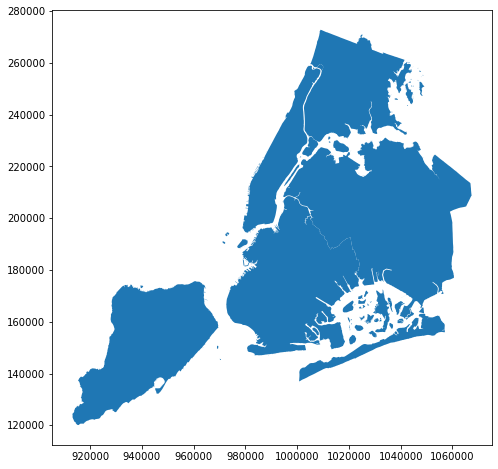

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
boros.plot(ax=ax)

Pretty cool! A plot of the NYC Boroughs just like that!

We can do all the same cool geometric operations to these GeoDataFrames as we could in `shapely`. Here we'll apply [convex hull](https://en.wikipedia.org/wiki/Convex_hull) and color each borough differently.

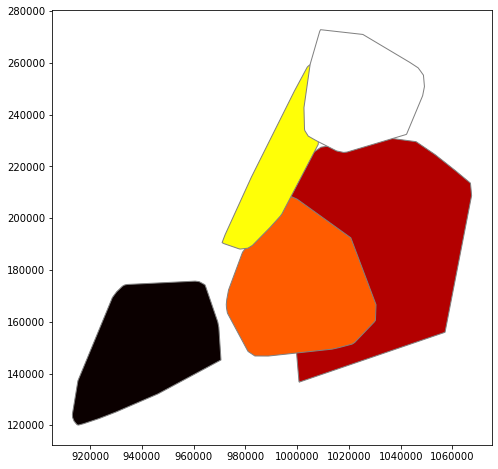

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
boros.geometry.convex_hull.plot(ax=ax, cmap='hot', edgecolor='gray')

Let's look at a dataset with some more attributes. GeoPandas comes pre-packaged with a `world` dataset that'll do.

In [24]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(5)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


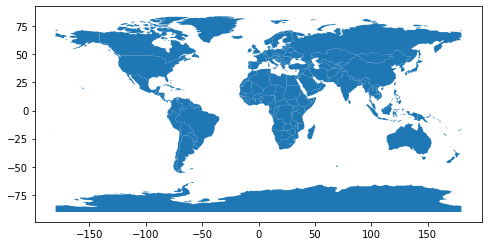

In [25]:
fig, ax = plt.subplots(figsize=(8,8)) 
world.plot(ax=ax)

With geopandas you can do filtering just like in any pandas dataframe

In [26]:
# find all countries with a population greater than 150 million
world[(world.pop_est > 150000000)]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."
8,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...
29,207353391,South America,Brazil,BRA,3081000.0,POLYGON ((-53.37366166849824 -33.7683777809007...
56,190632261,Africa,Nigeria,NGA,1089000.0,"POLYGON ((2.691701694356254 6.258817246928629,..."
98,1281935911,Asia,India,IND,8721000.0,"POLYGON ((97.32711388549004 28.26158274994634,..."
99,157826578,Asia,Bangladesh,BGD,628400.0,"POLYGON ((92.67272098182556 22.04123891854125,..."
102,204924861,Asia,Pakistan,PAK,988200.0,"POLYGON ((77.83745079947457 35.49400950778777,..."
139,1379302771,Asia,China,CHN,21140000.0,(POLYGON ((109.4752095886636 18.19770091396857...


We can filter all latitudes greater than 0 leaving only the southern hemisphere

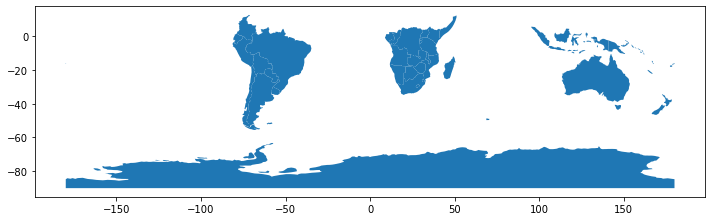

In [27]:
southern_world = world.cx[:, :0]

fig, ax = plt.subplots(figsize=(12,5)) 
southern_world.plot(ax=ax);

We can do more advanced filtering like combining the countries from each continent and then sorting continents by population.

In [28]:
world_filtered = world[['continent', 'geometry', 'pop_est']] # filter to only the columns we care about
continents = world_filtered.dissolve(by='continent', aggfunc='sum') # dissolve countries
continents

,geometry,pop_est
continent,,
Africa,(POLYGON ((49.54351891459575 -12.4698328589405...,1219176238
Antarctica,(POLYGON ((-163.7128956777287 -78.595667413241...,4050
Asia,(POLYGON ((120.2950142762069 -10.2586499976035...,4389144868
Europe,(POLYGON ((-51.65779741067889 4.15623240805302...,746398461
North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1...",573042112
Oceania,(POLYGON ((169.6678145693731 -43.5553256162263...,36782844
Seven seas (open ocean),"POLYGON ((68.935 -48.62500000000001, 69.58 -48...",140
South America,(POLYGON ((-66.95992000000001 -54.896810000000...,418540749


It is also really simple to create Chloropleth maps (maps where the color of each shape is based on the value of an
associated variable). 

Simply use the plot command with the column argument set to the column whose values you want used to assign colors.

Let's calculate and plot by GDP per capita

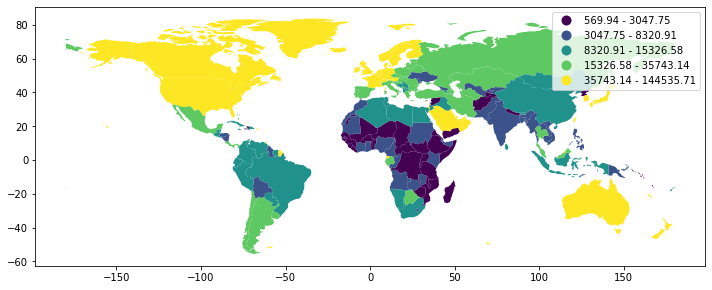

In [29]:
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
world['gdp_per_cap'] = world['gdp_per_cap'] * 1000000 # because it was calcualted in millionths

fig, ax = plt.subplots(figsize=(12,5))
world.plot(column='gdp_per_cap', legend=True, ax=ax, scheme='quantiles') # let's also add a colorbar
# and split groups into evenly sized ones with the quantiles keyword

We can also do complicated spatial intersections and unions over large datasets. Let's load a dataset of all glaciers, intersect them with countries, and then sort to find the countries with the most glacial coverage.

In [30]:
# load in the data
# data available from http://www.naturalearthdata.com/downloads/
glaciers = gpd.read_file("./data/shapefiles/ne_10m_glaciated_areas.shp")

This may take a moment to run because these dataframe joins can involve many operations.

In [31]:
# find the area containing both country and glacier
glacial_countries = gpd.overlay(world, glaciers, how='intersection') 
# this will generate an entry for each glacier and country pair
# dissolve all matching countries into one
glacial_countries = glacial_countries.dissolve(by='name_1', aggfunc='sum')
# create a column with area
glacial_countries['area'] = glacial_countries.geometry.area
# sort the dataframe by area and then display the top 5
glacial_countries.sort_values('area', ascending=False).head(5) 

,geometry,pop_est,gdp_md_est,gdp_per_cap,recnum,scalerank,min_zoom,area
name_1,,,,,,,,
Greenland,(POLYGON ((-53.03307044179132 67.2211367859315...,14255111,5.367310e+05,9.300002e+06,253453,1418,1332.4,543.269290
Canada,(POLYGON ((-139.8820694652288 61.1851260437441...,19414905600,9.123300e+08,2.561021e+07,217743,3051,2854.6,68.910882
Russia,(POLYGON ((45.60320071706292 42.56753164270239...,6828360912,1.797600e+08,1.263624e+06,55187,231,207.2,18.457040
Norway,(POLYGON ((6.502452019146176 60.24127838749399...,409643465,2.808190e+07,5.278508e+06,75237,374,328.2,13.835663
United States of America,(POLYGON ((-143.0681046214788 60.4491234395773...,39848346502,2.264320e+09,6.932459e+06,40533,584,524.3,12.594197


Merge that glacier area / country dataset back into the world dataset with all the countries

In [32]:
glacial_world = world.merge(glacial_countries, right_on='name_1', left_on='name')

In [33]:
# reset the geometry field which is required for a GeoDataFrame
glacial_world['geometry'] = glacial_world['geometry_x']
glacial_world = gpd.GeoDataFrame(glacial_world)

Now plot it with all countries being displayed by glacier coverage:

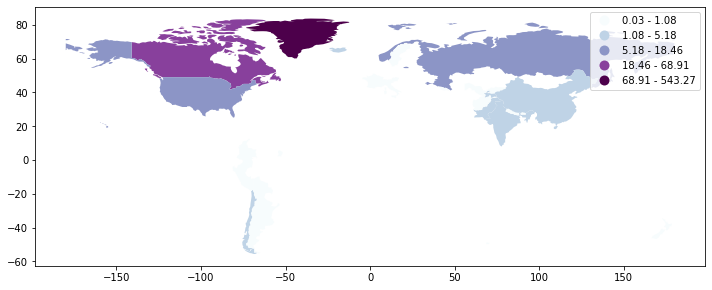

In [34]:
fig, ax = plt.subplots(figsize=(12,5))
glacial_world.plot(column='area', legend=True, ax=ax, scheme='fisher_Jenks', cmap='BuPu')

Let's take a look at some ocean data

In [35]:
# data available from http://www.naturalearthdata.com/downloads/
oceans = gpd.read_file("./data/shapefiles/ne_110m_ocean.shp")

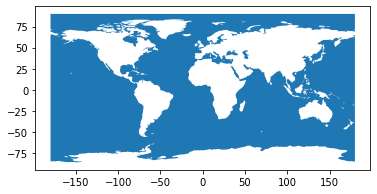

In [36]:
oceans.plot()

Let's overlay the oceans, countries, and glaciers

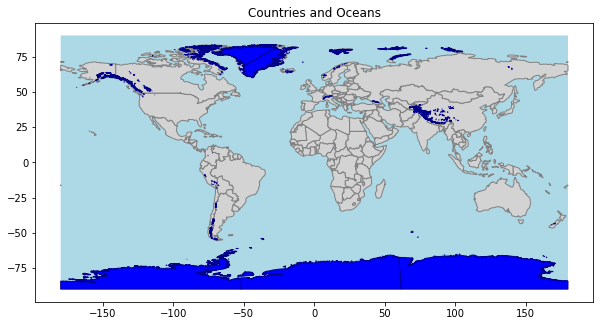

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Countries and Oceans')
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')
ax.set_aspect('equal')

Let's look at Anchorage Alaska at 61.2181° N, 149.9003° W

Note there are some mismatches between the glacier and land datasets because of the different resolutions

(-155, -145)

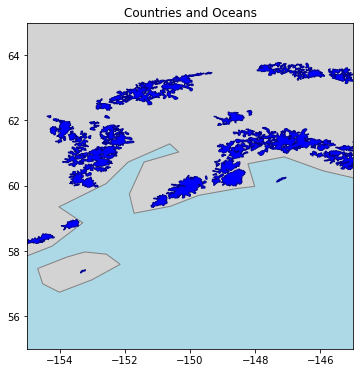

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Countries and Oceans')
oceans.plot(ax=ax, facecolor='lightblue')
world.plot(ax=ax, facecolor='lightgray', edgecolor='gray')
glaciers.plot(ax=ax, facecolor='blue', edgecolor='darkblue')

# specify a location by lat and long
ax.set_ylim([55, 65])
ax.set_xlim([-155, -145])

## BONUS KNOWLEDGE!!!

## Read from OGC WFS GeoJSON response into a GeoDataFrame

- This example drawn from https://geohackweek.github.io/vector/04-geopandas-intro/

#### Don't worry too much about the specifics here, this is an example just to show the power of these common formats for sharing data and getting really informative datasets from all sorts of databases

Use an Open Geospatial Consortium (OGC) Web Feature Service (WFS) request to obtain geospatial data from a remote source. OGC WFS is an open geospatial standard.

We won’t go into all details about what’s going on. Suffice it to say that we issue an OGC WFS request for all features from the layer named “oa:goainv” found in a GeoServer instance from NANOOS, requesting the response in GeoJSON format. Then we use the geojson package to “load” the raw response (a GeoJSON string) into a geojson feature object (a dictionary-like object).

The “oa:goainv” layer is a global dataset of monitoring sites and cruises where data relevant to ocean acidification are collected. It’s a work in progress from the Global Ocean Acidification Observation Network (GOA-ON); for additional information see the GOA-ON Data Portal.

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import geojson
import geopandas as gpd

# set up request parameters
wfs_url = "http://data.nanoos.org/geoserver/ows"
params = dict(service='WFS', version='1.0.0', request='GetFeature',
              typeName='oa:goaoninv', outputFormat='json')

# make the request
r = requests.get(wfs_url, params=params)
wfs_geo = geojson.loads(r.content)

# load world basemap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

Let’s examine the general characteristics of this GeoJSON object, including its __geo_interface__ interface, which we discussed earlier.

In [40]:
print(type(wfs_geo))
print(wfs_geo.keys())
print(len(wfs_geo.__geo_interface__['features']))

<class 'geojson.feature.FeatureCollection'>
dict_keys(['type', 'totalFeatures', 'crs', 'features'])
596


Now use the from_features constructor method to create a GeoDataFrame directly from the geojson.feature.FeatureCollection object.

In [41]:
wfs_gdf = gpd.GeoDataFrame.from_features(wfs_geo)

Finally, let’s visualize the data set as a simple map overlay plot; and as an example, display the values for the last feature.

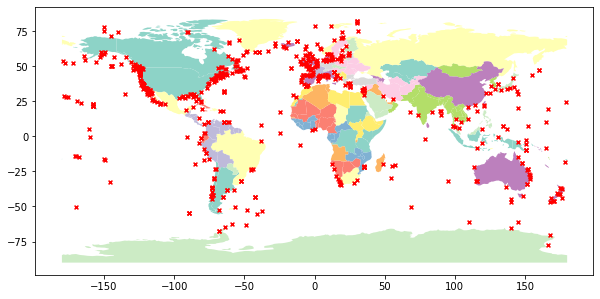

In [42]:
wfs_gdf.plot(ax=world.plot(cmap='Set3', figsize=(10, 6)),
             marker='x', markersize=15,  color='red');

What kind of data is contained in each of these points? Well let's take a glimpse:

In [43]:
wfs_gdf.iloc[0]

Oceans                                                    North Atlantic Ocean
additional_organizations                                                      
agency                                      Israeli Ministry of Infrastructure
city                                                                     Haifa
comments                                                                      
comments_about_overlaps                                                       
contact_email                                             jacobs1@ocean.org.il
contact_name                                                   Jacob Silverman
country                                                                 Israel
data_url                                                                      
department                                                                    
deploy_date                                                          01/2011 -
depth_range                                         